# End-to-End ML Project

**Premise**: need to predict median house price in each district in California

**Why**: to be used as input to another ML system (continuous value - not binned into cheap/mid/expensive)

**Dataset**: census data from US Census Bureau - has various features (e.g. median income, population, etc) along with median house price

**Regression task**: since we want to predict a continuous value

- **Multiple regression** : since using multiple features
- **Univariate regression** : since only predicting one value

**Supervised task**: since we have true "labels"

**Batch learning**: plain batch learning fine, since small dataset, no continuous input data flow

Performance measure: RMSE

\begin{equation}
\text{RMSE}(\pmb{X}, h) = \sqrt{\frac{1}{m} \sum_{i=1}^m \left(h(\pmb{x}^{(i)}) - y^{(i)}\right)^2}
\end{equation}

where

- have $m$ entries in data
- $\pmb{x}^{(i)}$ is the feature data for the  _i_ th entry
- $\pmb{X}$ is the data as a matrix: one row per entry, so $m$ rows. 
- $y^{(i)}$ is the label for entry _i_
- $h(\pmb{x}^{(i)})$ is the prediction for data entry _i_ using hypothesis $h$

Can also use mean absolute error, MAE, if outliers have too much of an effect.

More distances:

- RMSE is the $\ell_2$ norm, i.e. $||\cdot||_2$, the Euclidean distance

- MAE is the $\ell_1$ norm, i.e. $||\cdot||_1$, the Manhatten/taxicab distance

- $\ell_0$ is the size of the vector

- $\ell_{\inf}$ is the size of the largest element in the vector

- Generally: $||\pmb{v}||_k = (\sum |v_i|^k)^{1/k}$

- As $k$ increases, so does influence of outliers

## Getting/loading the dataset

In [1]:
# Download the input data as CSV
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [1]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [1]:
!ls -R datasets

datasets:
housing

datasets/housing:
housing.csv  housing.tgz


Now load it into a pandas DataFrame:

In [40]:
import numpy as np

In [143]:
np.__version__

'1.20.1'

In [149]:
np.set_printoptions(linewidth=100000, edgeitems=5)

In [2]:
import pandas as pd

In [3]:
pd.__version__

'1.2.2'

In [4]:
# Load the dataset
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [85]:
housing = load_housing_data()

In [86]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [87]:
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [88]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [89]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [90]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

## Quick n dirty insights into the data

In [91]:
%matplotlib inline

In [92]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [93]:
mpl.rcParams['font.size'] = 16  # this does nothing if seaborn activated
mpl.rcParams['figure.figsize'] = 12, 8

In [94]:
mpl.__version__

'3.3.4'

In [95]:
# if it's not using the virtualenvs one,
# you need to add your virtualenv to jupyter kernels, see README
mpl.__file__

'/Users/robin/.virtualenvs/handsonml/lib/python3.7/site-packages/matplotlib/__init__.py'

In [96]:
# removes the warning:
# "*c* argument looks like a single numeric RGB or RGBA sequence, 
# which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  
# Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points."
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [97]:
import seaborn as sns
sns.set_theme(style="darkgrid", font_scale=1.2)

In [98]:
sns.__version__

'0.11.1'

In [99]:
sns.__file__

'/Users/robin/.virtualenvs/handsonml/lib/python3.7/site-packages/seaborn/__init__.py'

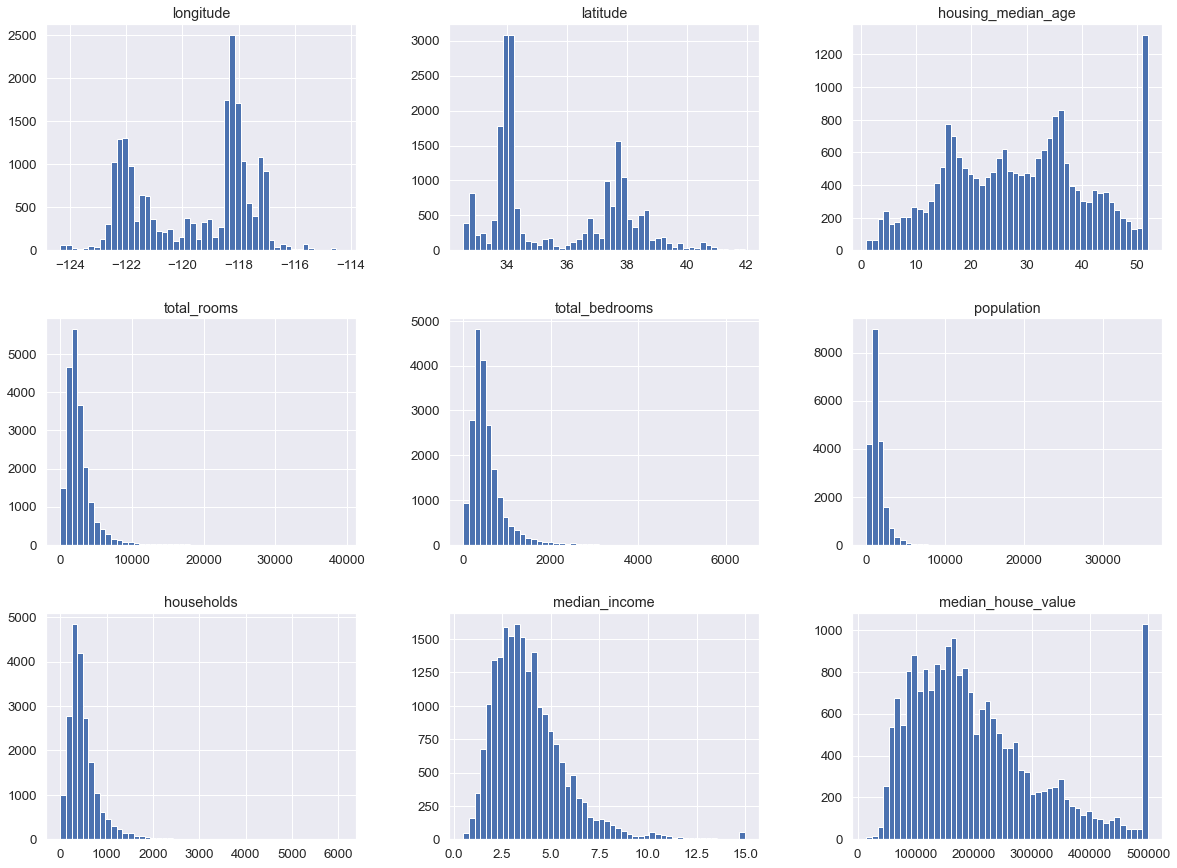

In [100]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

Can see that most distributions are skewed, with a long tail to larger values.

`median_house_value` and `housing_median_age` also both have issues, in that anything over 500K / 52 has been truncated to those values. So we might need to throw away those values.

`median_income` is also scaled oddly - looks like in 10Ks?

`total_rooms`, `total_bedrooms`, `population`, `households` are all summed across each district, hence why they look large (later on we will scale them more appropriately).

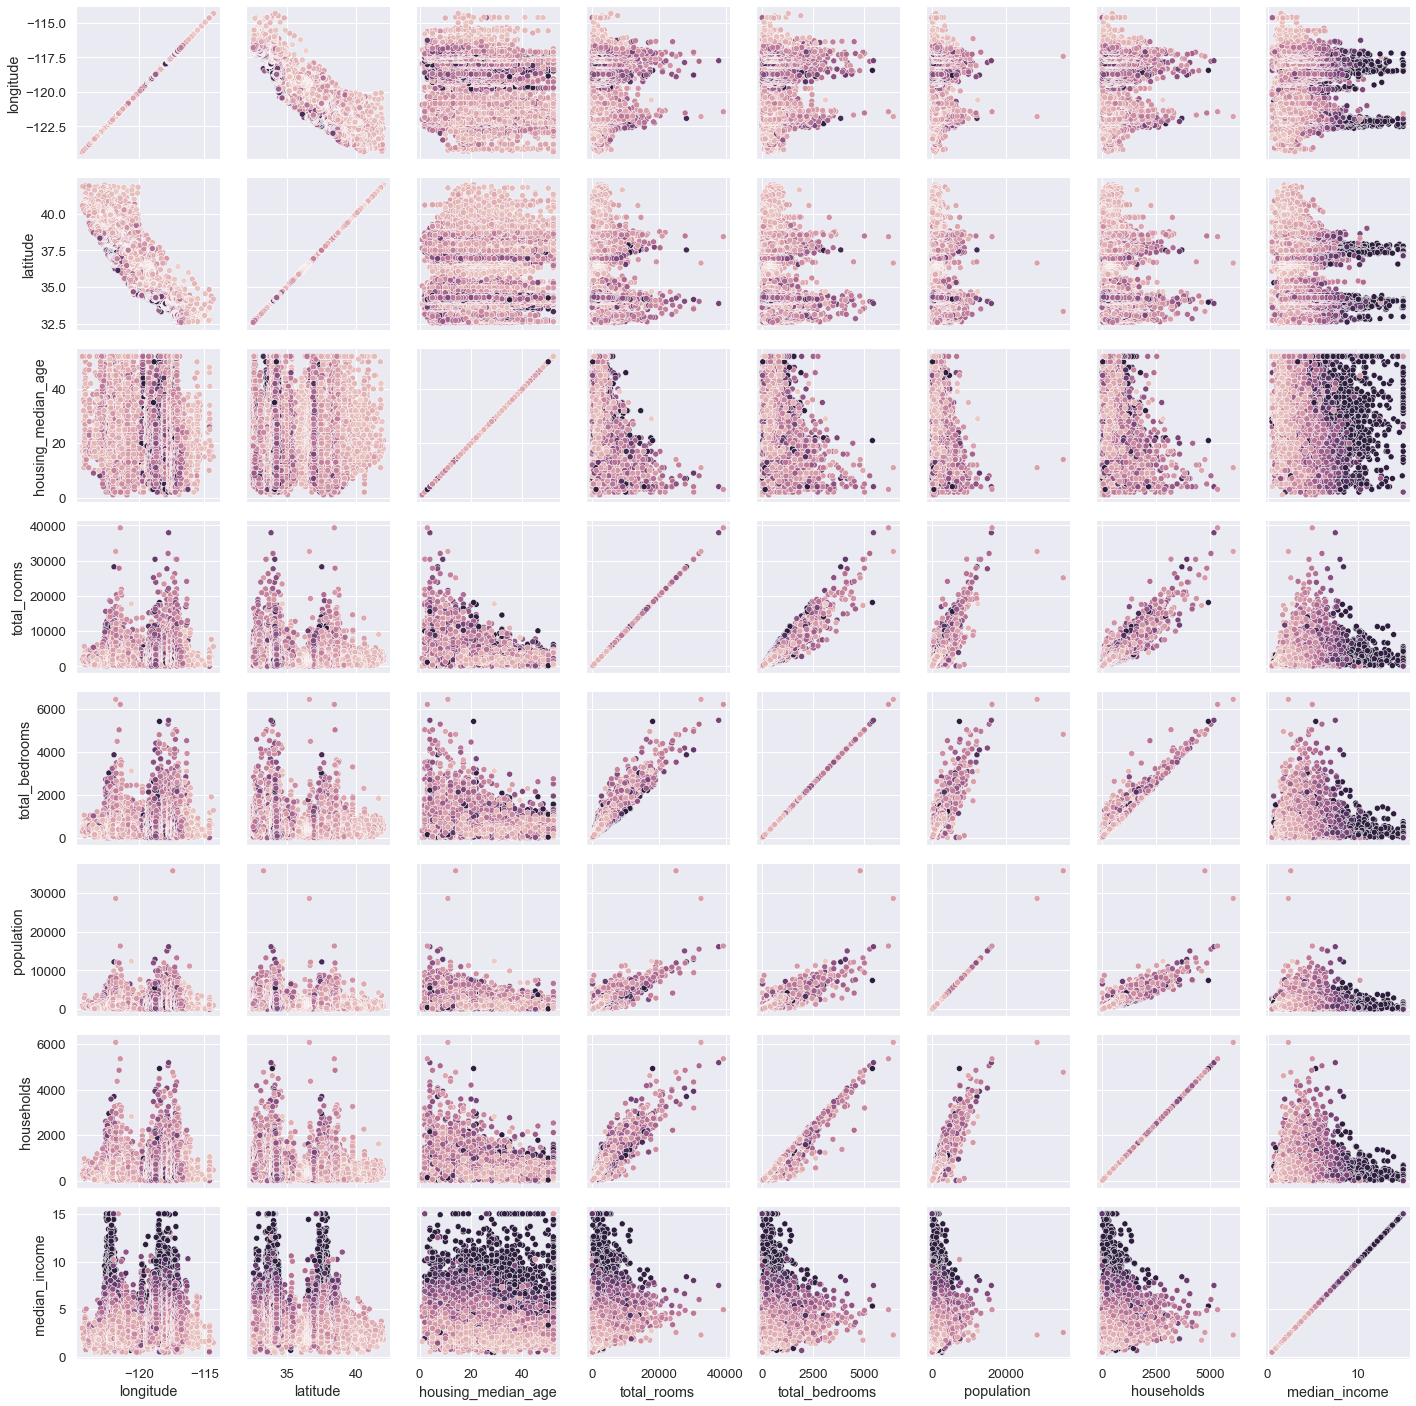

In [101]:
g = sns.PairGrid(housing, hue='median_house_value')
g.map(sns.scatterplot)

In [102]:
housing.corr()

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924664           -0.108197     0.044568   
latitude            -0.924664  1.000000            0.011173    -0.036100   
housing_median_age  -0.108197  0.011173            1.000000    -0.361262   
total_rooms          0.044568 -0.036100           -0.361262     1.000000   
total_bedrooms       0.069608 -0.066983           -0.320451     0.930380   
population           0.099773 -0.108785           -0.296244     0.857126   
households           0.055310 -0.071035           -0.302916     0.918484   
median_income       -0.015176 -0.079809           -0.119034     0.198050   
median_house_value  -0.045967 -0.144160            0.105623     0.134153   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069608    0.099773    0.055310      -0.015176   
latitude                 -0.066983   -0.108785   -0.071035      -0.079809   
housing_median_age       -0.320451   -0.296244   -0.302916      -0.119034   
total_rooms               0.930380    0.857126    0.918484       0.198050   
total_bedrooms            1.000000    0.877747    0.979728      -0.007723   
population                0.877747    1.000000    0.907222       0.004834   
households                0.979728    0.907222    1.000000       0.013033   
median_income            -0.007723    0.004834    0.013033       1.000000   
median_house_value        0.049686   -0.024650    0.065843       0.688075   

                    median_house_value  
longitude                    -0.045967  
latitude                     -0.144160  
housing_median_age            0.105623  
total_rooms                   0.134153  
total_bedrooms                0.049686  
population                   -0.024650  
households                    0.065843  
median_income                 0.688075  
median_house_value            1.000000

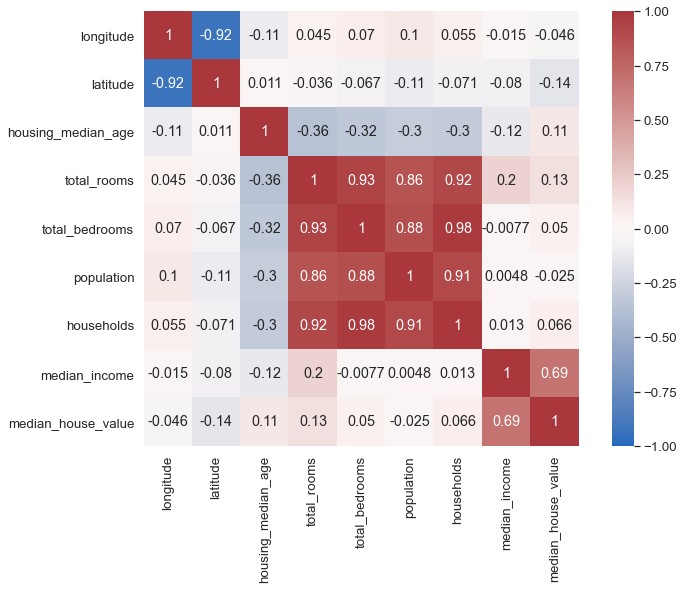

In [103]:
# since we're using Pearson's correlation coefficient,
# don't need a rescaling to compare variables with different scales
sns.heatmap(housing.corr(), cmap='vlag', vmin=-1, vmax=1, center=0, annot=True, square=True);

The only strong correlator that I can immediately identify for `median_house_value` is `median_income` (which makes sense: earn more, buy a more expensive house). Now, because `median_income` is not uniformly distributed, in order for us to create training/test sets, we must be sure to keep the same distribution in each: this is **stratified sampling**. The population is divided into homogeneous subgroups (**strata**), and then the right number of instances are sampled from each stratum.

Otherwise would introduce a **sampling bias**.

Also interesting is that `total_rooms`/`total_bedrooms` is _not_ strongly correlated with `median_house_value`, which is a bit surprising.

Can also see an inverse correlation between `housing_median_age` and `households`/`population`/`total_rooms` - if you're younger, you probably can't afford much, and need fewer rooms (less chance of kids, etc).

We can also see that there's a strong correlation amongst `{households, population, total_bedrooms, total_rooms}`, which may limit their utility - could condense down to 1 or 2 variables instead of needing all 4?

In [104]:
# bin the income to be able to stratify it:
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins=[0, 1.5, 3, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

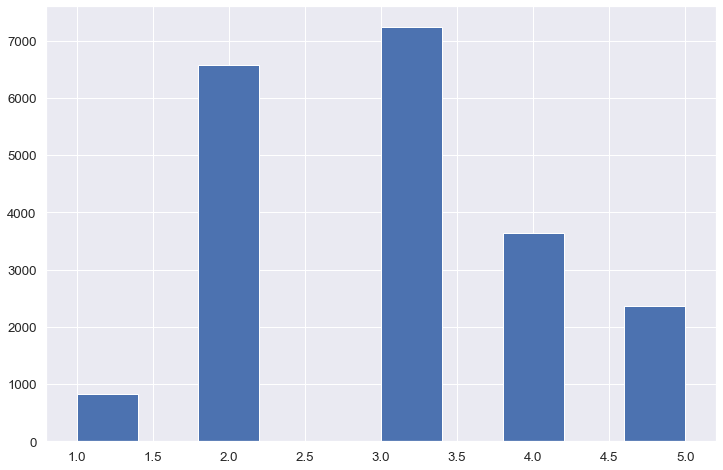

In [105]:
housing['income_cat'].hist()

In [106]:
import sklearn

In [107]:
sklearn.__version__

'0.24.1'

In [108]:
sklearn.__file__

'/Users/robin/.virtualenvs/handsonml/lib/python3.7/site-packages/sklearn/__init__.py'

In [109]:
# Do stratified selection
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [110]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [111]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

Comparing the fraction of rows in each income category, the training and test datasets looks v.similar. We can explicitly check the ratio (test / training) for each category, and see it is constant across categories:

In [112]:
strat_test_set['income_cat'].value_counts() / strat_train_set['income_cat'].value_counts()

3    0.249957
2    0.249953
4    0.250086
5    0.250397
1    0.249240
Name: income_cat, dtype: float64

In [113]:
# remove the income_cat col
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [114]:
housing = strat_train_set.copy()  # smaller version to play with, and avoid peeking at the test set

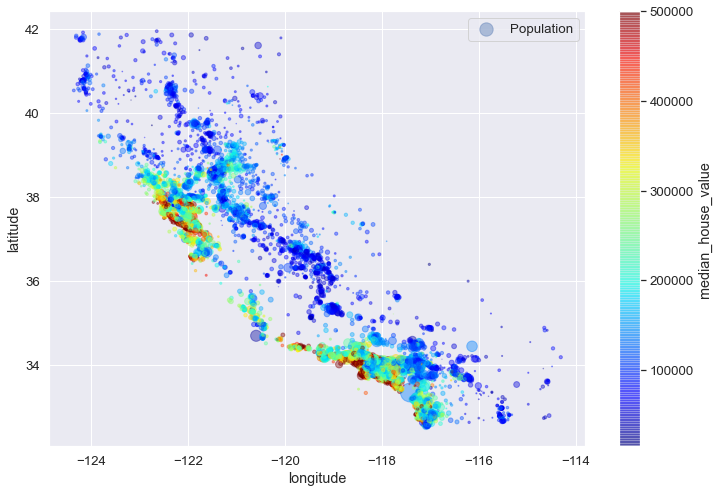

In [115]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='Population',
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
             sharex=False);

In [193]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income ocean_proximity  
17606       710.0       339.0         2.7042       <1H OCEAN  
18632       306.0       113.0         6.4214       <1H OCEAN  
14650       936.0       462.0         2.8621      NEAR OCEAN  
3230       1460.0       353.0         1.8839          INLAND  
3555       4459.0      1463.0         3.0347       <1H OCEAN

In [200]:
# only needed if you are runnign after splitting below
# housing_all = housing.copy()
# housing_all['median_house_value'] = housing_labels

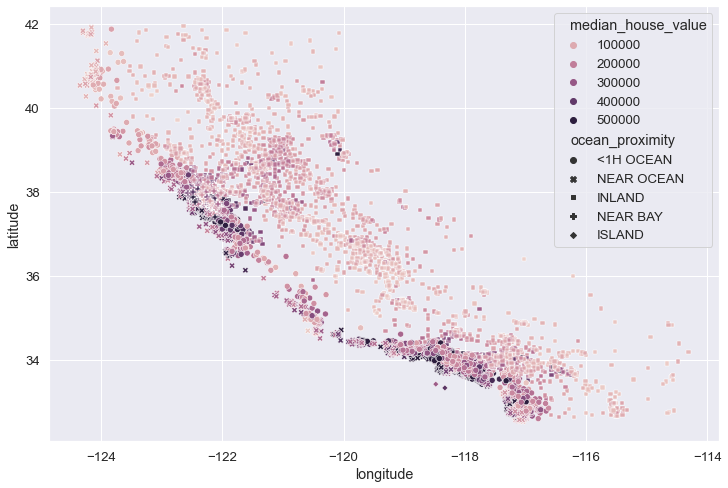

In [202]:
sns.scatterplot(data=housing_all, x='longitude', y='latitude', 
                style='ocean_proximity', hue='median_house_value');

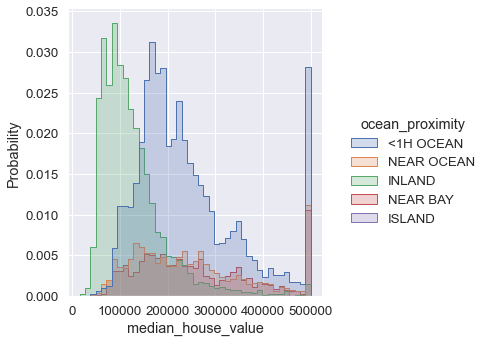

In [212]:
sns.displot(housing_all, x='median_house_value', 
            hue='ocean_proximity', kind='hist', 
            element="step", stat='probability');

So clearly there's a notable difference for INLAND - it tends to have much smaller median house values. The others are less obvious, e.g. near ocean is v.similar to near bay. 

In [116]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

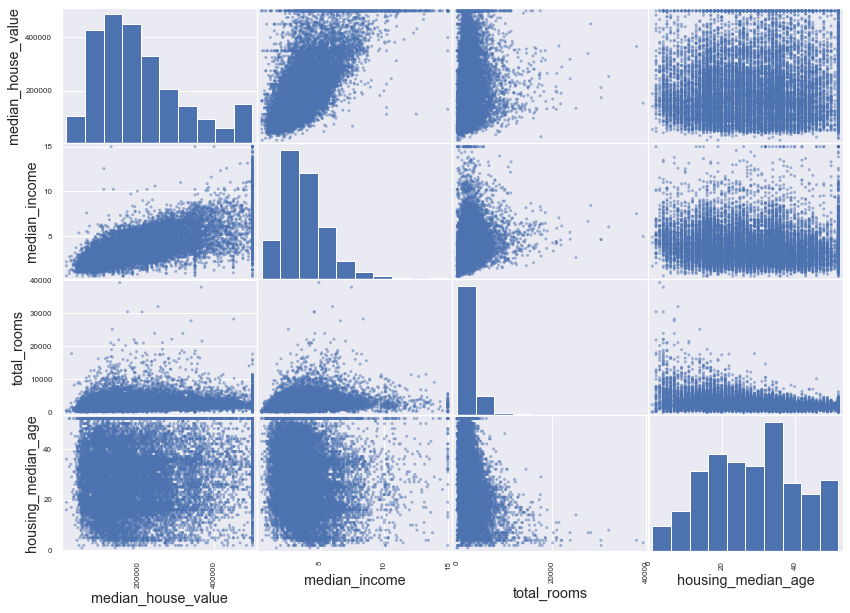

In [117]:
from pandas.plotting import scatter_matrix
attributes = corr_matrix['median_house_value'].sort_values(ascending=False).index[:4]
scatter_matrix(housing[attributes], figsize=(14, 10));

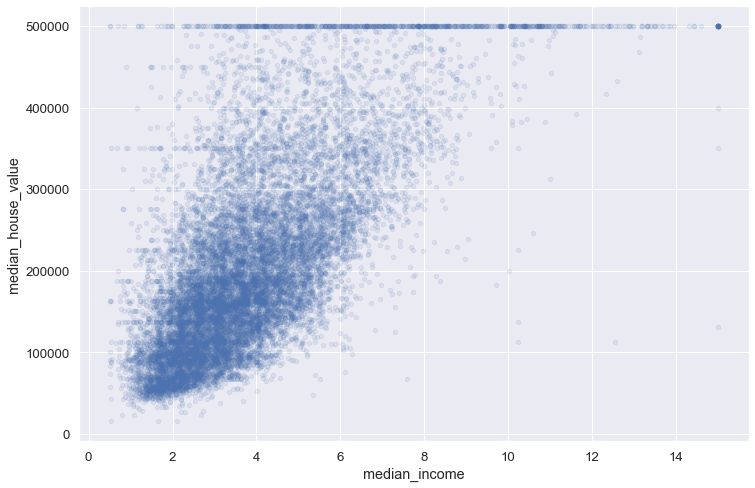

In [118]:
# Take a closer look at median_income, the strongest correlator
housing.plot(kind='scatter', x='median_income', y='median_house_value', 
             alpha=0.1);

Can see some spikes at certain house values: e.g. 350000, 225000

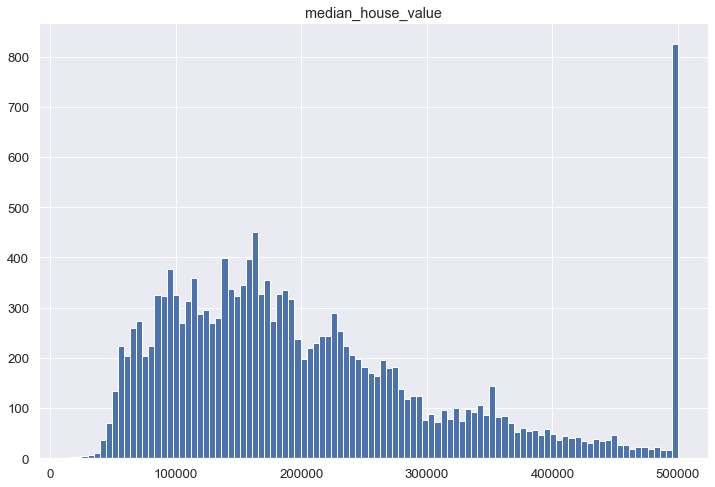

In [119]:
housing.hist('median_house_value', bins=100);

In [120]:
# create new attributes
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [121]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [122]:
corr_matrix['median_house_value'].abs().sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
bedrooms_per_room           0.259984
rooms_per_household         0.146285
latitude                    0.142724
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
longitude                   0.047432
population                  0.026920
population_per_household    0.021985
Name: median_house_value, dtype: float64

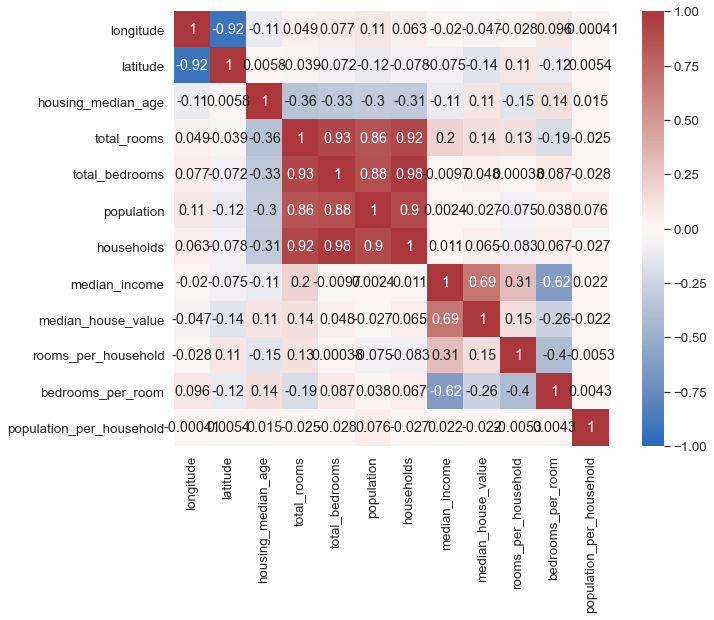

In [123]:
sns.heatmap(housing.corr(), cmap='vlag', vmin=-1, vmax=1, center=0, annot=True, square=True);

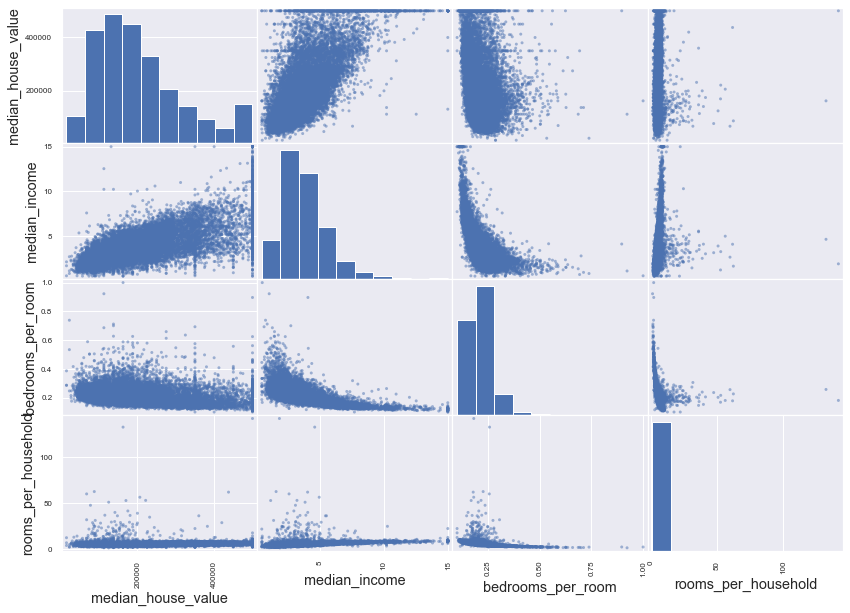

In [124]:
attributes = corr_matrix['median_house_value'].abs().sort_values(ascending=False).index[:4]
scatter_matrix(housing[attributes], figsize=(14, 10));

The new features are more interesting & relevant: `rooms_per_household` is also now more correlated than either `total_rooms` or `households`. `bedrooms_per_room` also has a notable negative correlation. But we also have some wild outliers, e.g. in rooms_per_household >> 100

## Proper data pipeline

In [125]:
# separate predictors from labels
housing = strat_train_set.drop('median_house_value', axis='columns')
housing_labels = strat_train_set['median_house_value'].copy()

In [126]:
# Create a custom transformer to create our new variables, 
# and so it can be used in a sklearn pipeline

# BaseEstimator - provides set/get_args() for hyperparam tuning
# TransformerMixin - provides fit_transform()
from sklearn.base import BaseEstimator, TransformerMixin

# column indices
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing to do, no params to figure out
    
    def transform(self, X):
        # note that X is a 2D numpy array
        # axis=0 is each entry row in dataset
        # axis=1 is each attribute column
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedroooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # here np.c_ stacks along the 2nd axis
            # so X goes from having [attrib1, attrib2, ..., attribN], each with m rows
            # to [attrib1, attrib2, ..., attribN, rooms_per_household, population_per_hosuehold, bedrooms_per_room],
            # each with m rows
            return np.c_[X, rooms_per_household, population_per_household, bedroooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Now we construct the total pipeline for numerical values:

- use median for replacing NA values in `total_bedrooms` (`SimpleImputer`)
- use our custom `CombinedAttributesAdder` to add new features
- rescale/**standardise** all numerical features to ensure same scale (`StandardScaler`) (don't use `MinMaxScaler`, since some variable have notable outliers which will mess with the scale of the "good" data points)

In [129]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num = housing.drop('ocean_proximity', axis=1)
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [150]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821, ..., -0.42069842, -0.61493744, -0.31205452, -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 , ..., -1.02222705,  1.33645936,  0.21768338, -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458, ..., -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,  0.4222004 ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594, ..., -0.38343559, -1.04556555, -0.07966124,  0.08973561, -0.19645314],
       [ 0.49247384, -0.65929936, -0.92673619,  1.85619316,  2.41221109, ...,  2.57097492, -0.44143679, -0.35783383, -0.00419445,  0.2699277 ],
       ...,
       [ 0.72226706, -0.67333121,  1.37954692, -0.63212323, -0.72536126, ..., -0.76404883,  0.55415776,  0.23435165, -0.03175508, -0.42885278],
       [ 1.00701085, -0.8230043 ,  0.9023849 , -0.66719629, -0.58418268, ..., -0.63629054, -0.94881466, -0.30811439,  0.0846

And we need another transformer for categorical data, which we'll combine with `num_pipeline` into one big pipeline

In [139]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

# remeber housing & housing_prepared are the training dataset only
housing_prepared = full_pipeline.fit_transform(housing)

In [135]:
type(housing_prepared)

numpy.ndarray

In [133]:
housing_prepared.dtype

dtype('float64')

In [134]:
housing_prepared.shape

(16512, 16)

## Select & Train a Model

### Linear regression

In [137]:
# Try a simple LinearRegression model, which we expect to be a bit naff
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Note that the API for these predictors is `fit()` then `predict()` (instead of `transform()` for the Transformers)

In [147]:
# Test it out on some data from training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
predictions = lin_reg.predict(some_data_prepared)
print("Predictions:", predictions)
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


NB predictions were not scaled in transformer, hence why not in [-1, 1].

In [152]:
# More quantative across whole training set
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_mse = np.sqrt(lin_mse)
print('linear model:', lin_mse)

68628.19819848922


Clearly, this is a bit rubbish - it's implying a 68K average error on properties with value ~ 200K. The model is **underfitting** - either the features are not powerful enough, or the model is not.

We should probably try a more powerful model.

### Decision Tree + k-fold cross-validation

In [153]:
# Try with a decision tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [155]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_mse = np.sqrt(tree_mse)
print('Decision tree:', tree_mse)

Decision tree: 0.0


Perfect predictor? Or more likely it's overfit -> need a validation set to test it out

Use **K-fold cross-validation**: split training sample into training + validation samples, using k distinct subsets called **folds**. Train on k-1 folds, then evaluate on leftout fold. Then have k metrics to evaluate.

Need to use a **utility** function (bigger is better) instead of a **cost** function (smaller is better) like RMSE. So here we just use the -ve of RMSE

Also note that `cross_val_score` automatically does all the fitting etc.

**This is good for evaluating the model, and its hyperparameters, without touching the test st** - after CV, we pick the best model, then **train it on the full training set**, then evaluate it on the test set.

In [156]:
# Do k-fold cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [157]:
def display_scores(scores):
    print("scores:", scores)
    print("Mean:", scores.mean())
    print("Std:", scores.std())

In [158]:
display_scores(tree_rmse_scores)

scores: [69992.56408127 69153.97309512 70078.81337803 69363.19149682 69927.4653418  75244.11036461 69448.27266603 70522.88394946 76528.65012561 71417.8619745 ]
Mean: 71167.77864732612
Std: 2453.728881789651


So the decision tree is even worse than the Linear model! It seems to overfit on its training data, then generalises badly to new data.

In [159]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

In [160]:
display_scores(lin_rmse_scores)

scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552 68031.13388938 71193.84183426 64969.63056405 68281.61137997 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Std: 2731.6740017983493


### Random forest (decision tree++)

We try an even more complex model, this time using ensemble learning, here a Random forest regressor.

In [161]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [162]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_mse = np.sqrt(forest_mse)
print('Random forest:', forest_mse)

Random forest: 18659.43336945046


In [163]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                         scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [164]:
display_scores(forest_rmse_scores)

scores: [49412.80080339 47469.95101583 49820.73544397 52405.20927872 49558.84641999 53524.25727379 48997.34079025 48136.64701926 52844.28914498 50180.97219555]
Mean: 50235.10493857407
Std: 1929.3916710563624


This is better than either a linear regression or a simple decision tree, but it still isn't good. Again, it's still overfitting (since score on training set is so much better than in CV).

### Fine tuning models

Use GridSearch to tune hyperparameters

In [182]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try this set of 5*3 = 15 parameters
    {'n_estimators': [10, 30, 50, 100, 300], 'max_features': [4, 6, 8]},
    # then this set of 1 * 2 * 3 = 6
    #     {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2,3,4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ....................max_features=4, n_estimators=10; total time=   0.5s
[CV] END ....................max_features=4, n_estimators=10; total time=   0.4s
[CV] END ....................max_features=4, n_estimators=10; total time=   0.4s
[CV] END ....................max_features=4, n_estimators=10; total time=   0.4s
[CV] END ....................max_features=4, n_estimators=10; total time=   0.4s
[CV] END ....................max_features=4, n_estimators=30; total time=   1.2s
[CV] END ....................max_features=4, n_estimators=30; total time=   1.4s
[CV] END ....................max_features=4, n_estimators=30; total time=   1.2s
[CV] END ....................max_features=4, n_estimators=30; total time=   1.3s
[CV] END ....................max_features=4, n_estimators=30; total time=   1.4s
[CV] END ....................max_features=4, n_estimators=50; total time=   2.1s
[CV] END ....................max_features=4, n_e

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [4, 6, 8],
                          'n_estimators': [10, 30, 50, 100, 300]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [183]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 300}

In [184]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=300)

In [185]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

53048.16770683721 {'max_features': 4, 'n_estimators': 10}
50372.050223264116 {'max_features': 4, 'n_estimators': 30}
49984.11698797009 {'max_features': 4, 'n_estimators': 50}
49802.31363125841 {'max_features': 4, 'n_estimators': 100}
49557.13959739748 {'max_features': 4, 'n_estimators': 300}
52537.172162558694 {'max_features': 6, 'n_estimators': 10}
49901.23459910997 {'max_features': 6, 'n_estimators': 30}
49546.10914719696 {'max_features': 6, 'n_estimators': 50}
49331.42352489036 {'max_features': 6, 'n_estimators': 100}
49125.735248581215 {'max_features': 6, 'n_estimators': 300}
51966.968182425204 {'max_features': 8, 'n_estimators': 10}
49988.43818935461 {'max_features': 8, 'n_estimators': 30}
49624.068589645154 {'max_features': 8, 'n_estimators': 50}
49434.39959245751 {'max_features': 8, 'n_estimators': 100}
49194.07570227471 {'max_features': 8, 'n_estimators': 300}


So the best score is just under 50000, so a bit better than the default Random Forest. But having n_estimators = 30 means we hit the boundary of phase space. Also added larger values of n_estimators, but with diminishing returns (and much longer training times, e.g. 16s per fold for 300, vs 5s per fold for 100). It seems that an ever increasing number of n_estimators improve the score, but by smaller amounts - probably not learning much new?

In [189]:
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

[7.65348934e-02 6.77710360e-02 4.30870750e-02 1.79530107e-02 1.66361076e-02 1.75894098e-02 1.63288633e-02 3.38028675e-01 6.21975780e-02 1.06679292e-01 7.05985210e-02 1.26102227e-02 1.44174760e-01 7.75029343e-05 4.11314141e-03 5.61991102e-03]


In [190]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3380286748330507, 'median_income'),
 (0.14417476029107915, 'INLAND'),
 (0.10667929199760953, 'pop_per_hhold'),
 (0.07653489337452754, 'longitude'),
 (0.0705985209969599, 'bedrooms_per_room'),
 (0.06777103601817874, 'latitude'),
 (0.062197578000191385, 'rooms_per_hhold'),
 (0.04308707502583182, 'housing_median_age'),
 (0.01795301069063053, 'total_rooms'),
 (0.01758940983729328, 'population'),
 (0.016636107586301175, 'total_bedrooms'),
 (0.016328863255812995, 'households'),
 (0.012610222732735998, '<1H OCEAN'),
 (0.005619911015788562, 'NEAR OCEAN'),
 (0.004113141409730515, 'NEAR BAY'),
 (7.750293427816474e-05, 'ISLAND')]

So median_income is important (as we guessed), as is pop_per_hhold. INLAND is also of interest, although the others are not. You can see this in the map: inland has no high median_house_prices, but being near the coast does: except it doesn't really matter what sort of coast it is.

Now can run on test dataset:

In [213]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [214]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [215]:
print("final rmse:", final_rmse)

final rmse: 46721.96410487863


Get 95% confidence interval:

In [217]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([44782.10200768, 48584.43371502])

### Analyzing residuals

We can look at the residuals to see if there's anything of interest:

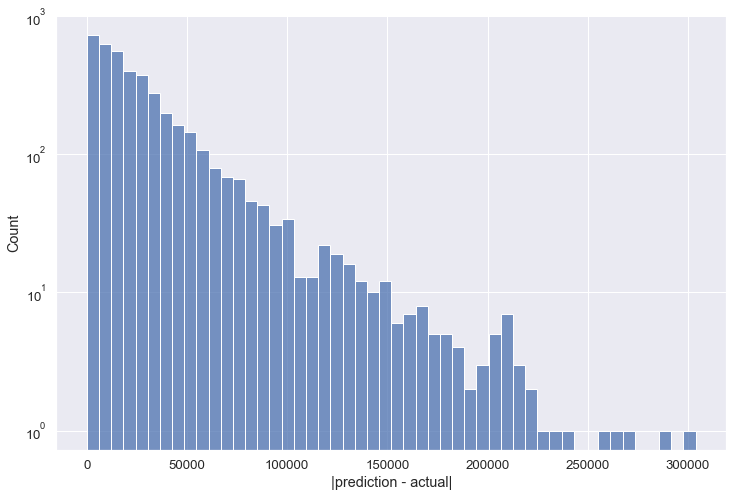

In [230]:
sns.histplot(np.sqrt(squared_errors), bins=50);
plt.yscale('log');
plt.xlabel("|prediction - actual|");

So we can see that the bulk of the squared_errors are v.small, but there are some that are radically wrong, that drive up the mean. The median root squared error (ie absolute diff) is much smaller:

In [366]:
print('mean:', np.sqrt(squared_errors).mean())
print('median:', np.sqrt(squared_errors).median())

mean: 31277.753311531003
median: 20709.33333333333


Let's look at the prediction vs true values to see if there are any features of interest:

Text(0, 0.5, 'true value')

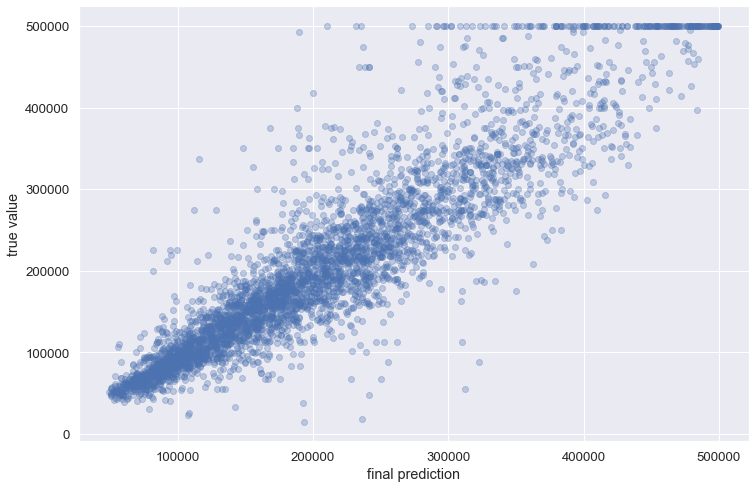

In [237]:
plt.scatter(final_predictions, y_test, alpha=0.3)
plt.xlabel('final prediction')
plt.ylabel('true value')

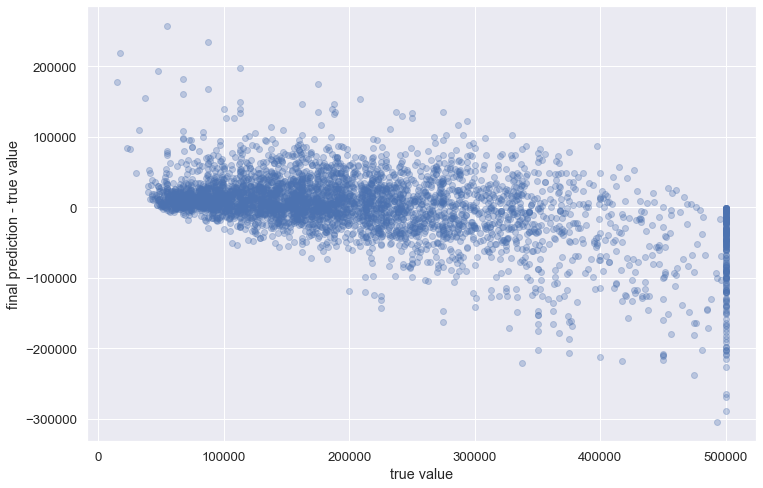

In [241]:
plt.scatter(y_test, final_predictions - y_test, alpha=0.3);
plt.ylabel('final prediction - true value');
plt.xlabel('true value');

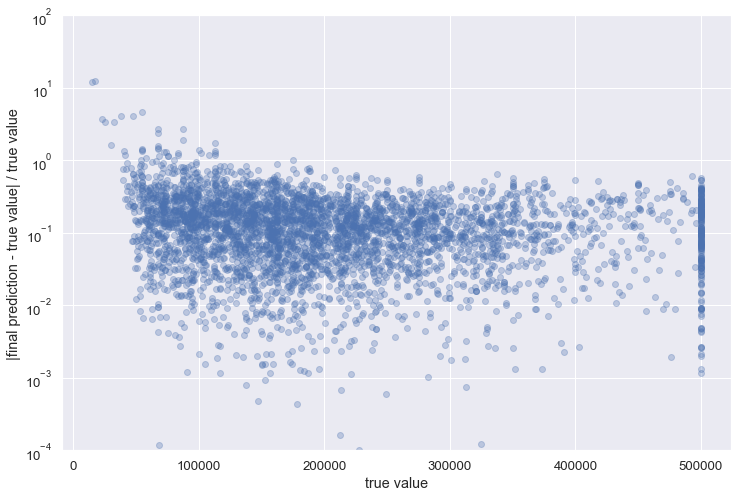

In [268]:
plt.scatter(y_test, np.abs(final_predictions - y_test) / y_test, alpha=0.3);
plt.ylabel('|final prediction - true value| / true value');
plt.xlabel('true value');
plt.yscale('log');
plt.ylim(1E-4, 1E2);

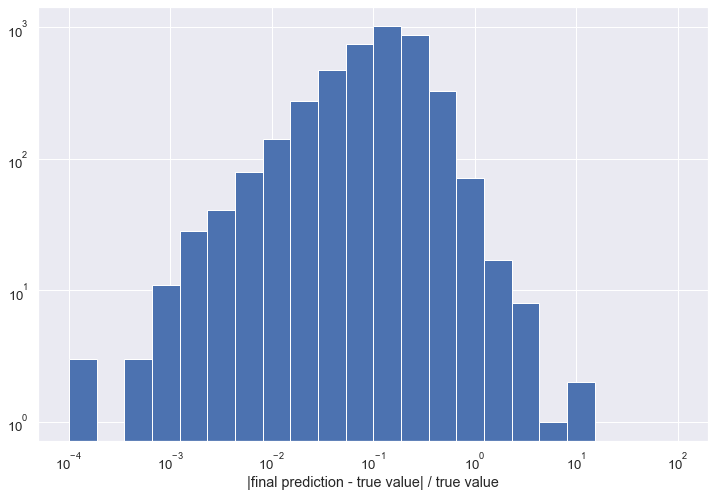

In [295]:
# Bin in log space since it covers so many orders of magnitude
plt.hist(np.abs(final_predictions - y_test) / y_test, bins=np.logspace(-4, 2, 23))
plt.yscale('log');
plt.xscale('log');
plt.xlabel('|final prediction - true value| / true value');


Interestingly, there appears to be some sort of trend, where it  over-predicts at small values, and under-predicts as the true value increases

In [247]:
mask = final_predictions - y_test > 200000

In [248]:
y_test[mask]

5887    17500.0
5388    55000.0
8222    87500.0
Name: median_house_value, dtype: float64

In [249]:
final_predictions[mask]

array([236420.37666667, 312005.46333333, 322748.83333333])

So we have 3 points where the prediction is ~200-300K, but the true values are significantly smaller (<< 100K)

In [251]:
X_test.loc[mask]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
5887    -118.33     34.15                39.0        493.0           168.0   
5388    -118.39     34.03                19.0       1450.0           509.0   
8222    -118.23     33.76                21.0         49.0            14.0   

      population  households  median_income ocean_proximity  
5887       259.0       138.0         2.3667       <1H OCEAN  
5388       746.0       437.0         3.1415       <1H OCEAN  
8222        29.0        16.0         5.0000      NEAR OCEAN

In [252]:
X_test_prepared[mask,:]

array([[ 0.62235696, -0.69671763,  0.8228579 , -0.99594773, -0.89088098, -1.04045916, -0.95568627, -0.79211285, -0.71521418, -0.10528106,  1.94462392,  1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.59238393, -0.75284504, -0.76768218, -0.54841554, -0.06084827, -0.60394329, -0.15985858, -0.38537061, -0.81261913, -0.11993151,  2.10169787,  1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.67231201, -0.87913171, -0.60862818, -1.20358022, -1.26573447, -1.24661655, -1.28040526,  0.59027529, -0.91048044, -0.11083259,  1.10204772,  0.        ,  0.        ,  0.        ,  0.        ,  1.        ]])

In [356]:
max_frac = 0.2
mask_all = (np.abs(final_predictions - y_test) / y_test ) > max_frac

In [357]:
mask_all.sum() / len(y_test)

0.28875968992248063

So ~30% have a relative error > 20% (the baseline accuracy from human experts).

In [303]:
X_test.loc[mask_all]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
16531    -121.20     37.81                26.0        395.0            74.0   
10383    -117.64     33.62                16.0       3970.0           771.0   
5986     -117.71     34.10                52.0        567.0           152.0   
11316    -117.97     33.77                25.0       1295.0           417.0   
4614     -118.29     34.08                43.0       3056.0          1345.0   
...          ...       ...                 ...          ...             ...   
3239     -119.56     36.09                35.0       1648.0           285.0   
20519    -121.53     38.58                33.0       4988.0          1169.0   
17430    -120.44     34.65                30.0       2265.0           512.0   
12107    -117.32     33.99                27.0       5464.0           850.0   
2398     -118.91     36.79                19.0       1616.0           324.0   

       population  households  median_income ocean_proximity  
16531       193.0        72.0         7.3718          INLAND  
10383      1202.0       734.0         3.4115       <1H OCEAN  
5986       2688.0       126.0         1.8750          INLAND  
11316       856.0       342.0         2.7157       <1H OCEAN  
4614       3920.0      1304.0         1.9250       <1H OCEAN  
...           ...         ...            ...             ...  
3239        792.0       265.0         3.2847          INLAND  
20519      2414.0      1075.0         1.9728          INLAND  
17430      1402.0       471.0         1.9750      NEAR OCEAN  
12107      2400.0       836.0         4.7110          INLAND  
2398        187.0        80.0         3.7857          INLAND  

[1192 rows x 9 columns]

Why is bedrooms_per_room, pop_per_hhold, and rooms_per_hhold -ve? Have -ve total_rooms, or -ve population. Ah because **after** StandardScaling. So we need to undo that part, then put it into a dataframe. Complicated slightly by the one-hot encoded columns, so we drop those, then re-add them into the dataframe.

In [339]:
std_scaler = num_pipeline.named_steps['std_scaler']
X_test_prepared_inverse = std_scaler.inverse_transform(X_test_prepared[:, 0:11])

In [343]:
df_test = pd.DataFrame(np.c_[X_test_prepared_inverse, X_test_prepared[:, 11:]], 
                       columns=attributes, index=X_test.index)  # need to use original index
df_test['median_house_value'] = y_test
df_test['predicted_house_value'] = final_predictions

In [344]:
df_test.describe()

longitude     latitude  housing_median_age   total_rooms  \
count  4128.000000  4128.000000         4128.000000   4128.000000   
mean   -119.545187    35.600998           28.585029   2687.902132   
std       2.010260     2.127489           12.630172   2345.868226   
min    -124.180000    32.550000            1.000000      2.000000   
25%    -121.780000    33.920000           18.000000   1474.000000   
50%    -118.455000    34.220000           28.000000   2158.500000   
75%    -117.980000    37.690000           37.000000   3171.000000   
max    -114.560000    41.950000           52.000000  32627.000000   

       total_bedrooms    population  households  median_income  \
count     4128.000000   4128.000000  4128.00000    4128.000000   
mean       548.101502   1448.220446   509.45688       3.850998   
std        451.885172   1197.088364   407.59254       1.879270   
min          1.000000      5.000000     1.00000       0.499900   
25%        302.000000    805.750000   283.00000       2.543000   
50%        438.000000   1172.000000   416.00000       3.514750   
75%        651.000000   1754.000000   613.00000       4.739700   
max       6445.000000  28566.000000  6082.00000      15.000100   

       rooms_per_hhold  pop_per_hhold  bedrooms_per_room    <1H OCEAN  \
count      4128.000000    4128.000000        4128.000000  4128.000000   
mean          5.383637       2.967526           0.214092     0.450581   
std           1.822611       1.584630           0.064481     0.497612   
min           0.846154       1.089286           0.048767     0.000000   
25%           4.434536       2.425183           0.175614     0.000000   
50%           5.218776       2.823084           0.203442     0.000000   
75%           6.031716       3.286534           0.240091     1.000000   
max          37.063492      63.750000           1.151596     1.000000   

            INLAND       ISLAND     NEAR BAY   NEAR OCEAN  median_house_value  \
count  4128.000000  4128.000000  4128.000000  4128.000000         4128.000000   
mean      0.312016     0.000727     0.107316     0.129360       206315.401647   
std       0.463372     0.026952     0.309552     0.335639       114170.048854   
min       0.000000     0.000000     0.000000     0.000000        14999.000000   
25%       0.000000     0.000000     0.000000     0.000000       118975.000000   
50%       0.000000     0.000000     0.000000     0.000000       181300.000000   
75%       1.000000     0.000000     0.000000     0.000000       269025.000000   
max       1.000000     1.000000     1.000000     1.000000       500001.000000   

       predicted_house_value  
count            4128.000000  
mean           207629.126335  
std             99841.299098  
min             49402.333333  
25%            131442.833333  
50%            189868.213333  
75%            263543.767500  
max            499418.983333

In [345]:
df_test.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
5241     -118.39     34.12                29.0       6447.0          1012.0   
10970    -117.86     33.77                39.0       4159.0           655.0   
20351    -119.05     34.21                27.0       4357.0           926.0   
6568     -118.15     34.20                52.0       1786.0           306.0   
13285    -117.68     34.07                32.0       1775.0           314.0   

       population  households  median_income  rooms_per_hhold  pop_per_hhold  \
5241       2184.0       960.0         8.2816         6.715625       2.275000   
10970      1669.0       651.0         4.6111         6.388633       2.563748   
20351      2110.0       876.0         3.0119         4.973744       2.408676   
6568       1018.0       322.0         4.1518         5.546584       3.161491   
13285      1067.0       302.0         4.0375         5.877483       3.533113   

       bedrooms_per_room  <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN  \
5241            0.156972        1.0     0.0     0.0       0.0         0.0   
10970           0.157490        1.0     0.0     0.0       0.0         0.0   
20351           0.212532        1.0     0.0     0.0       0.0         0.0   
6568            0.171333        0.0     1.0     0.0       0.0         0.0   
13285           0.176901        0.0     1.0     0.0       0.0         0.0   

       median_house_value  predicted_house_value  
5241             500001.0          486804.836667  
10970            240300.0          279116.020000  
20351            218200.0          222124.670000  
6568             182100.0          209771.666667  
13285            121300.0          138062.333333

In [346]:
df_test[mask]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
5887    -118.33     34.15                39.0        493.0           168.0   
5388    -118.39     34.03                19.0       1450.0           509.0   
8222    -118.23     33.76                21.0         49.0            14.0   

      population  households  median_income  rooms_per_hhold  pop_per_hhold  \
5887       259.0       138.0         2.3667         3.572464       1.876812   
5388       746.0       437.0         3.1415         3.318078       1.707094   
8222        29.0        16.0         5.0000         3.062500       1.812500   

      bedrooms_per_room  <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN  \
5887           0.340771        1.0     0.0     0.0       0.0         0.0   
5388           0.351034        1.0     0.0     0.0       0.0         0.0   
8222           0.285714        0.0     0.0     0.0       0.0         1.0   

      median_house_value  predicted_house_value  
5887             17500.0          236420.376667  
5388             55000.0          312005.463333  
8222             87500.0          322748.833333

Do a scatter matrix for the more important variables, split by "good" predictions (red) and "bad" ones (blue), to see if any obvious regions of phase space where they aren't modelled well.

['median_income', 'INLAND', 'pop_per_hhold', 'longitude', 'bedrooms_per_room']


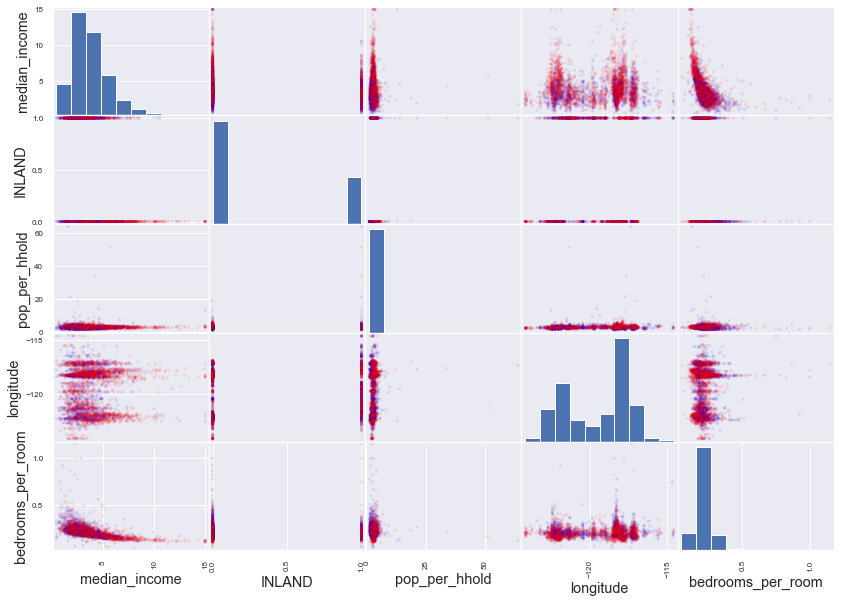

In [358]:
important_attribs = [b for a,b in sorted(zip(feature_importances, attributes), reverse=True)][:5]
print(important_attribs)
df_good = ((df_test['median_house_value'] - df_test['predicted_house_value']).abs() / df_test['median_house_value']) < max_frac
colours = df_good.map(lambda x: 'red' if x else 'blue')
scatter_matrix(df_test[important_attribs], figsize=(14, 10), color=colours, alpha=0.1);

There doesn't seem to be anything obvious here...

## Exercises

### 1. Try a SVM

Try Supprt Vector Machine regressor with both linear & rbf (radial basis function) kernels, and varying C (& gamma for rbf).

In [359]:
from sklearn.svm import SVR

In [360]:
svm_reg = SVR(kernel='rbf', gamma='scale', C=1)
svm_reg.fit(housing_prepared, housing_labels)
scores = cross_val_score(svm_reg, housing_prepared, housing_labels, 
                         scoring='neg_mean_squared_error', cv=10)
svm_rmse_scores = np.sqrt(-scores)

In [361]:
display_scores(svm_rmse_scores)

scores: [111389.0681902  119541.25938571 116957.62830414 120447.19932481 117618.15904234 122309.10351544 117634.40230741 121469.713921   120343.01369623 118017.12860651]
Mean: 118572.66762937943
Std: 2936.8775867949425


So a plain SVR with rbf kernel is pretty rubbish. Let's try a grid search with varying parameters: (this is slowwwww)

In [364]:
param_grid = [
    {'kernel': ['rbf'], 'C': [0.1, 10, 100], 'gamma': [0.1, 10, 100]},
    {'kernel': ['linear'], 'C': [0.1, 10, 100]}
]

svm_reg = SVR()

svm_grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=2)
svm_grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  18.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  18.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  21.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  19.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  19.0s
[CV] END ........................C=0.1, gamma=10, kernel=rbf; total time=  22.6s
[CV] END ........................C=0.1, gamma=10, kernel=rbf; total time=  23.0s
[CV] END ........................C=0.1, gamma=10, kernel=rbf; total time=  22.7s
[CV] END ........................C=0.1, gamma=10, kernel=rbf; total time=  22.6s
[CV] END ........................C=0.1, gamma=10, kernel=rbf; total time=  21.5s
[CV] END .......................C=0.1, gamma=100, kernel=rbf; total time=  16.7s
[CV] END .......................C=0.1, gamma=100

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.1, 10, 100], 'gamma': [0.1, 10, 100],
                          'kernel': ['rbf']},
                         {'C': [0.1, 10, 100], 'kernel': ['linear']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [368]:
print('Best params:', svm_grid_search.best_params_)
print('Best score:', np.sqrt(-svm_grid_search.best_score_))
print("All results:")
cvres = svm_grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

Best params: {'C': 100, 'kernel': 'linear'}
Best score: 71603.17709602808
All results:
118893.04078565264 {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
118923.11185953725 {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
118923.16771777988 {'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}
116179.91589503165 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
118917.49972219949 {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
118923.37221383187 {'C': 10, 'gamma': 100, 'kernel': 'rbf'}
98579.0475235823 {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
118888.47284683697 {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
118925.26067156605 {'C': 100, 'gamma': 100, 'kernel': 'rbf'}
118248.96638734567 {'C': 0.1, 'kernel': 'linear'}
84654.24944894915 {'C': 10, 'kernel': 'linear'}
71603.17709602808 {'C': 100, 'kernel': 'linear'}


We can see that the nest score is only 70K, so worse than for random forest. We also hit the edge of our phase space. Let's try again:

In [369]:
param_grid = [
    {'kernel': ['rbf'], 'C': [100, 1000], 'gamma': [0.001, 0.01, 0.1]},
    {'kernel': ['linear'], 'C': [100, 1000, 10000]}
]

svm_reg = SVR()

svm_grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=2)
svm_grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=  18.2s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=  17.6s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=  17.9s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=  17.5s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=  17.6s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=  17.5s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=  17.6s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=  17.6s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=  17.3s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=  17.8s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=  17.3s
[CV] END .......................C=100, gamma=0.1,

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [100, 1000], 'gamma': [0.001, 0.01, 0.1],
                          'kernel': ['rbf']},
                         {'C': [100, 1000, 10000], 'kernel': ['linear']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [370]:
print('Best params:', svm_grid_search.best_params_)
print('Best score:', np.sqrt(-svm_grid_search.best_score_))
print("All results:")
cvres = svm_grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

Best params: {'C': 10000, 'kernel': 'linear'}
Best score: 70374.76835424894
All results:
117624.56209896787 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
109140.10105809168 {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
98579.0475235823 {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
107358.79831098409 {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
78424.12113068477 {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
71925.33585324521 {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
71603.17709602808 {'C': 100, 'kernel': 'linear'}
70445.38351530985 {'C': 1000, 'kernel': 'linear'}
70374.76835424894 {'C': 10000, 'kernel': 'linear'}


NB large values of C take **a long time** (minutes for ~1E6)

In [371]:
param_grid = [
    {'kernel': ['linear'], 'C': [1E3, 1E4, 1E5, 1E6]}
]

svm_reg = SVR()

svm_grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=2)
svm_grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ............................C=1000.0, kernel=linear; total time=   9.8s
[CV] END ............................C=1000.0, kernel=linear; total time=  10.0s
[CV] END ............................C=1000.0, kernel=linear; total time=  10.2s
[CV] END ............................C=1000.0, kernel=linear; total time=  10.0s
[CV] END ............................C=1000.0, kernel=linear; total time=   9.7s
[CV] END ...........................C=10000.0, kernel=linear; total time=  13.4s
[CV] END ...........................C=10000.0, kernel=linear; total time=  12.5s
[CV] END ...........................C=10000.0, kernel=linear; total time=  13.2s
[CV] END ...........................C=10000.0, kernel=linear; total time=  12.7s
[CV] END ...........................C=10000.0, kernel=linear; total time=  12.8s
[CV] END ..........................C=100000.0, kernel=linear; total time=  41.1s
[CV] END ..........................C=100000.0, ke

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [1000.0, 10000.0, 100000.0, 1000000.0],
                          'kernel': ['linear']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [373]:
print('Best params:', svm_grid_search.best_params_)
print('Best score:', np.sqrt(-svm_grid_search.best_score_))
print("All results:")
cvres = svm_grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

Best params: {'C': 100000.0, 'kernel': 'linear'}
Best score: 70352.55303522923
All results:
70445.38351530985 {'C': 1000.0, 'kernel': 'linear'}
70374.76835424894 {'C': 10000.0, 'kernel': 'linear'}
70352.55303522923 {'C': 100000.0, 'kernel': 'linear'}
70356.40828339866 {'C': 1000000.0, 'kernel': 'linear'}


Our best model seems to be with a linear kernel, with large values of C (1E4 - 1E5), although even larger values (1E6) doesn't improve performance (variation per score >> difference in scores). But overall a SVR isn't as good as a Random forest (~70K vs ~50K score), even tweaking the hyperparameters (we seem to get diminishing returns for ever larger C).

### 2. Try randomized search

Use RandomizedSearchCV instead of GridSearchCV

In [408]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import betabinom, randint

# have to specify probability distributions for each parameter
param_distr = {
    # these must be disrete distributions since it wants ints, not continuous
    'n_estimators': betabinom(n=300, a=2, b=1),
    'max_features': randint(4, 10),
}

forest_reg = RandomForestRegressor()

rand_search = RandomizedSearchCV(forest_reg, param_distr, cv=5, n_iter=10,
                                 scoring='neg_mean_squared_error',
                                 return_train_score=True, verbose=2)
rand_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................max_features=6, n_estimators=294; total time=  16.4s
[CV] END ...................max_features=6, n_estimators=294; total time=  15.5s
[CV] END ...................max_features=6, n_estimators=294; total time=  15.4s
[CV] END ...................max_features=6, n_estimators=294; total time=  15.6s
[CV] END ...................max_features=6, n_estimators=294; total time=  15.9s
[CV] END ...................max_features=7, n_estimators=172; total time=  10.3s
[CV] END ...................max_features=7, n_estimators=172; total time=  10.5s
[CV] END ...................max_features=7, n_estimators=172; total time=  10.7s
[CV] END ...................max_features=7, n_estimators=172; total time=  10.4s
[CV] END ...................max_features=7, n_estimators=172; total time=  10.2s
[CV] END ...................max_features=7, n_estimators=116; total time=   7.0s
[CV] END ...................max_features=7, n_es

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x164cbbb50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x168ecc890>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=2)

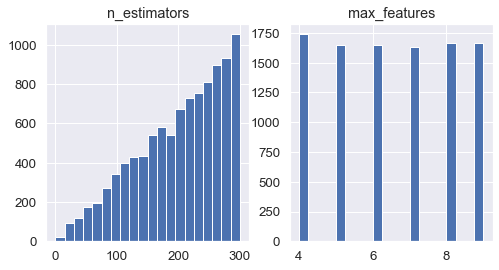

In [409]:
n_params = len(param_distr)
fig, axes = plt.subplots(1, n_params, figsize=(8, 4))
for k, ax in zip(param_distr.keys(), axes):
    r = param_distr[k].rvs(size=10000)
    ax.hist(r, bins=20)
    ax.set_title(k)

In [410]:
print('Best params:', rand_search.best_params_)
print('Best score:', np.sqrt(-rand_search.best_score_))
print("All results:")
cvres = rand_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

Best params: {'max_features': 6, 'n_estimators': 294}
Best score: 48967.14279798633
All results:
48967.14279798633 {'max_features': 6, 'n_estimators': 294}
49079.1011245083 {'max_features': 7, 'n_estimators': 172}
49332.70109688402 {'max_features': 7, 'n_estimators': 116}
49083.66532236314 {'max_features': 8, 'n_estimators': 259}
49326.76993456302 {'max_features': 9, 'n_estimators': 127}
49381.51254972125 {'max_features': 4, 'n_estimators': 295}
49207.348457878354 {'max_features': 5, 'n_estimators': 239}
49504.69907494865 {'max_features': 4, 'n_estimators': 288}
49492.49395982796 {'max_features': 4, 'n_estimators': 187}
49355.53869696367 {'max_features': 9, 'n_estimators': 107}


Notably, we get a slightly better score over the same phase space than using GridSearch.

In [413]:
forest_reg_best = RandomForestRegressor(**rand_search.best_params_)
forest_reg_best.fit(housing_prepared, housing_labels)

RandomForestRegressor(max_features=6, n_estimators=294)

### 3. Create transformer to only select most important features

In [415]:
forest_reg_best.feature_importances_

array([7.46122138e-02, 6.88322259e-02, 4.29725534e-02, 1.79472438e-02, 1.66673783e-02, 1.78341364e-02, 1.64470086e-02, 3.32972959e-01, 5.57540166e-02, 1.07377467e-01, 7.95972354e-02, 1.06991795e-02, 1.49149446e-01, 7.39743479e-05, 3.54685871e-03, 5.51610293e-03])

In [417]:
np.argsort(forest_reg_best.feature_importances_)

array([13, 14, 15, 11,  6,  4,  5,  3,  2,  8,  1,  0, 10,  9, 12,  7])

In [423]:
forest_reg_best.feature_importances_[np.argsort(forest_reg_best.feature_importances_)[-1:-5:-1]]

array([0.33297296, 0.14914945, 0.10737747, 0.07959724])

In [430]:
np.sort(np.argsort(forest_reg_best.feature_importances_)[-5:-1])

array([ 0,  9, 10, 12])

In [435]:
forest_reg_best.feature_importances_[np.sort(np.argsort(forest_reg_best.feature_importances_)[-5:-1])]

array([0.07461221, 0.10737747, 0.07959724, 0.14914945])

In [436]:
np.array(attributes)[np.sort(np.argsort(forest_reg_best.feature_importances_)[-5:-1])]

array(['longitude', 'pop_per_hhold', 'bedrooms_per_room', 'INLAND'], dtype='<U18')

In [431]:
class ImportantFeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_importances, n):
        self.feature_importances = feature_importances
        self.n = n
        
    def fit(self, X, y=None):
        # calculate indices of n largest values in feature_importances
        self.feature_indices = np.sort(np.argsort(self.feature_importances)[-self.n-1:-1])
        return self  # nothing to do, no params to figure out
    
    def transform(self, X):
        return X[:, self.feature_indices]

In [444]:
# we can build a pipeline from an existing pipeline or column transformer
prep_and_select_pipeline = Pipeline([
    ('prep', full_pipeline),
    ('select', ImportantFeatureSelector(forest_reg_best.feature_importances_, 5))
])

housing_prepared_top_k_features = prep_and_select_pipeline.fit_transform(housing)

In [439]:
housing_prepared_top_k_features[0:3]


array([[-1.15604281,  0.77194962, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  0.6596948 , -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -1.34218285, -0.09240499,  0.4222004 ,  0.        ]])

In [443]:
housing_prepared[:3,np.sort(np.argsort(forest_reg_best.feature_importances_)[-6:-1])]


array([[-1.15604281,  0.77194962, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  0.6596948 , -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -1.34218285, -0.09240499,  0.4222004 ,  0.        ]])

### 4. Single pipeline

Make a pipeline that does the fitting as well

In [456]:
n_features = 5  # must match for ImportantFeatureSelector and RandomForestRegressor, otherwise error
prep_select_fit_pipeline = Pipeline([
    ('prep', full_pipeline),
    ('select', ImportantFeatureSelector(forest_reg_best.feature_importances_, n_features)),
    ('fit', RandomForestRegressor(max_features=n_features, n_estimators=rand_search.best_params_['n_estimators'])),
])

In [457]:
prep_select_fit_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                           

In [463]:
print('predictions:', prep_select_fit_pipeline.predict(housing[:4]).tolist())
print('actual:', housing_labels[:4].tolist())

predictions: [280529.5918367347, 342328.60544217686, 199550.0, 55493.87755102041]
actual: [286600.0, 340600.0, 196900.0, 46300.0]


### 5. Explore preparation options using GridSearchCV